## Compressed Sensing

In [1]:
import numpy as np
from numpy.fft import *
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm

# Load Image
m = loadmat('SUBMIT/M.mat')['M']

### Assignment a
(4 marks) Generate a random undersampling pattern ($U_R$) and a variable density random undersampling pattern ($U_{VDR}$), both with acceleration factor of 4. Each sampling pattern must be a matrix with 1s in the sampled positions and 0s in the remaining ones. Obtain the corresponding PSFs and compare them. Obtained the aliased images as a result of undersampling with the generated patterns. For this you should use:
$$b=F^{-1}UFm$$
where m is the fully sampled image, U is the corresponding undersampling pattern, F is the Fourier transform and b is the aliased image. Depict the aliased images for the different undersampling patterns and compare against the fully sampled image.

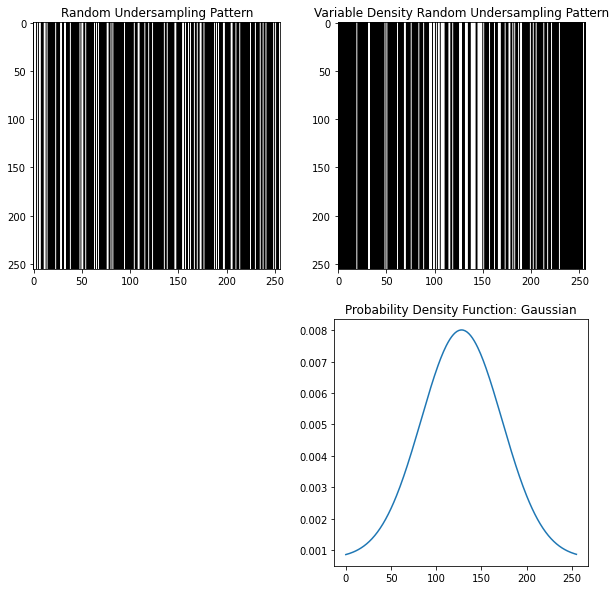

In [2]:
UR=np.zeros_like(m)
UVDR=np.zeros_like(m)

UR[:,np.random.choice(256,256//4, replace=False)]=1
sigma=1e3
bias=1e-1
p=np.exp(-(np.arange(256)-128)**2/(2*sigma*2))+bias
p/=np.sum(p)
UVDR[:,np.random.choice(256,256//4, replace=False, p=p)]=1

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(UR, cmap='gray')
plt.title("Random Undersampling Pattern")
plt.subplot(2,2,2)
plt.imshow(UVDR, cmap='gray')
plt.title("Variable Density Random Undersampling Pattern")
plt.subplot(2,2,4)
plt.title("Probability Density Function: Gaussian")
plt.plot(p)
plt.show()

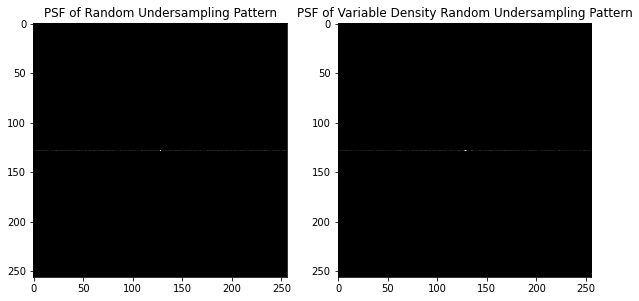

In [3]:
PSF_UR = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(UR)))
PSF_UVDR = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(UVDR)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(PSF_UR), cmap='gray')
plt.title("PSF of Random Undersampling Pattern")
plt.subplot(1,2,2)
plt.imshow(np.abs(PSF_UVDR), cmap='gray')
plt.title("PSF of Variable Density Random Undersampling Pattern")
plt.show()


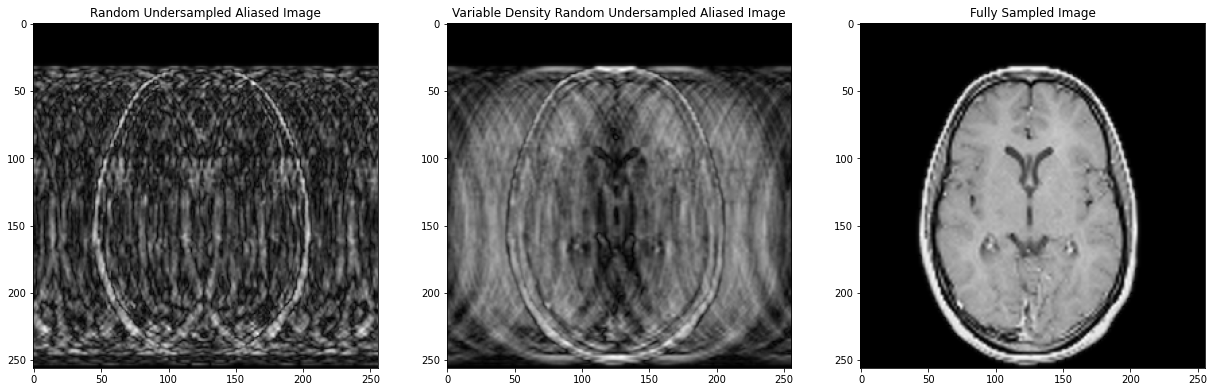

In [4]:
b_UR = fftshift(ifft2(ifftshift(UR*fftshift(fft2(ifftshift(m))))))
b_UVDR = fftshift(ifft2(ifftshift(UVDR*fftshift(fft2(ifftshift(m))))))

plt.figure(figsize=(21,7))
plt.subplot(1,3,1)
plt.imshow(np.abs(b_UR), cmap='gray')
plt.title("Random Undersampled Aliased Image")
plt.subplot(1,3,2)
plt.imshow(np.abs(b_UVDR), cmap='gray')
plt.title("Variable Density Random Undersampled Aliased Image")
plt.subplot(1,3,3)
plt.imshow(np.abs(m), cmap='gray')
plt.title("Fully Sampled Image")
plt.show()

### Assignment b
(6 marks) Select one algorithm, among those available on internet (some of these are listed below, and you can use any other algorithms you found), to solve the Compressed Sensing problem with Total Variation regularization. Download the software and briefly describe each of the algorithms, you can use the test examples, usually provided together with these softwares, for your description.
Examples of algorithms:
+ L1-magic https://statweb.stanford.edu/~candes/software/l1magic/
+ NESTA https://statweb.stanford.edu/~candes/software/nesta/
+ TWIST http://www.lx.it.pt/~bioucas/TwIST/TwIST.htm
+ SALSA http://cascais.lx.it.pt/~mafonso/salsa.html